In [111]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))

from utils import *

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

sns.set_style('ticks')

## 0. Read and inspect data files

In [112]:
input_path = '../Data'

feature_file = 'deepnose_features.npy'
CID_file = 'molecules_train_cid.npy'

mixture_file = 'Mixure_Definitions_Training_set.csv'
training_task_file = 'TrainingData_mixturedist.csv'

# Deepnose features
features = np.load(os.path.join(input_path, feature_file))
# Training dataframe
training_set = pd.read_csv(os.path.join(input_path, training_task_file))

# Mapping helper files
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))
features_CIDs = np.load(os.path.join(input_path, CID_file))

#### Standard transform:

In [113]:
# Standard transform features:
scaler = StandardScaler(with_mean=True, with_std=True)
sdt_features = scaler.fit_transform(features)

# Map CID to 96 dim features:
CID2sdtfeatures =  {CID: sdt_features[i] for i, CID in enumerate(features_CIDs)}

#### Try out log standardization:

In [114]:
scaler = StandardScaler(with_mean=True, with_std=True)
epsilon = 1e-8 
log_features = scaler.fit_transform(np.log(features + epsilon))

# Map CID to 96 dim features:
CID2logfeatures =  {CID: log_features[i] for i, CID in enumerate(features_CIDs)}

- each `x` in `X` contains a two vector tuple `(mixture_1, mixture_2)`, index ordered same way as `training_set`
- `method` specifies the ways to create the mixture embeeding from 

In [115]:
# X, y, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2features, method = 'log', beta = 5)
X_sdt_avg, y, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2sdtfeatures, method = 'avg', beta = None)
X_sdt_log, y, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2sdtfeatures, method = 'log', beta = 5)
X_log_avg, y, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2logfeatures, method = 'avg', beta = None)

- `X_diff`: feature wise difference, if `method = log`, then diff would be division; if `method = avg`, diff would be subtraction.

- `X_features`:  add more engineered measures to `X_diff`:

    - Eucledian distance;
    - Cosyne similarity (0, 1);
    - Angle (0, pi/2);
    - shared number of molecules between pair;
    - different number of molecules between pair;
    - one-hot of the dataset its from


In [116]:
# Convert the input pairs to a suitable format for training
# X_diff = np.array([np.divide(x1, x2) for x1, x2 in X])
X_diff1 = np.array([x1 - x2 for x1, x2 in X_sdt_avg])
X_diff2= np.array([np.divide(x1, x2) for x1, x2 in X_sdt_log])
X_diff3 = np.array([x1 - x2 for x1, x2 in X_log_avg])

y_true = np.array(y)

In [117]:
distances_1 = [get_euclidean_distance(m[0], m[1]) for m in X_sdt_avg]
similarities_1 = [get_cosine_similarity(m[0], m[1]) for m in X_sdt_avg]
angles_1 = [get_cosine_angle(m[0], m[1]) for m in X_sdt_avg]

distances_2 = [get_euclidean_distance(m[0], m[1]) for m in X_sdt_log]
similarities_2 = [get_cosine_similarity(m[0], m[1]) for m in X_sdt_log]
angles_2 = [get_cosine_angle(m[0], m[1]) for m in X_sdt_log]

distances_3 = [get_euclidean_distance(m[0], m[1]) for m in X_log_avg]
similarities_3 = [get_cosine_similarity(m[0], m[1]) for m in X_log_avg]
angles_3 = [get_cosine_angle(m[0], m[1]) for m in X_log_avg]


In [118]:
shared_monos = [ len( set(pair[0]).intersection(set(pair[1]))) for pair in all_pairs_CIDs]
diff_monos = [ len( set(pair[0]).difference(set(pair[1]))) for pair in all_pairs_CIDs]

In [119]:
datasets = training_set['Dataset'].to_numpy()
encoder = OneHotEncoder()
data_arr = encoder.fit_transform(datasets.reshape(-1, 1))
data_arr = data_arr.toarray()

In [120]:
### add all information above
X_features = np.hstack((X_diff1, X_diff2, X_diff3,
                        np.array([distances_1, similarities_1, angles_1, distances_2, similarities_2, angles_2, distances_3, similarities_3, angles_3]).reshape(500, 9), 
                        np.array(shared_monos).reshape(500, 1), 
                        np.array(diff_monos).reshape(500, 1), 
                        np.array(num_mixtures), 
                        data_arr))

In [121]:
X_features.shape

(500, 305)

----
## 2. Training
### 2.1 Example attempt, standard intialized RF and XGBoost

In [122]:
n_folds = 10
seed = 314159

In [123]:
rf_pred_list = []
xgb_pred_list = []
y_true_list = []
test_indices_list = []  # Keep track of the test indices in each fold

# Perform k-fold cross-validation:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(X_features):
    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y_true[train_index], y_true[test_index]
    
    # Train the Random Forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=seed)
    rf.fit(X_train, y_train)
    
    # Train the XGBoost regressor
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=seed)
    xgb_model.fit(X_train, y_train)
    
    # Make predictions 
    rf_pred = rf.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    
    rf_pred_list.extend(rf_pred)
    xgb_pred_list.extend(xgb_pred)
    y_true_list.extend(y_test)
    test_indices_list.extend(test_index)  # Store the test indices

# Store the predictions and actual values
results_df = pd.DataFrame({
    'test_index': test_indices_list,
    'rf_pred': rf_pred_list,
    'xgb_pred': xgb_pred_list,
    'y_true': y_true_list
})

# Merge the results with the training_set df
training_set = training_set.merge(results_df, left_index=True, right_on='test_index')
training_set.drop('test_index', axis=1, inplace=True)

In [124]:
training_set.head()

,Dataset,Mixture 1,Mixture 2,Experimental Values,rf_pred,xgb_pred,y_true
150,Snitz 1,1,2,0.604167,0.570182,0.469039,0.604167
300,Snitz 1,1,3,0.651042,0.637195,0.673614,0.651042
0,Snitz 1,1,5,0.505208,0.557820,0.535549,0.505208
1,Snitz 1,1,6,0.411458,0.550273,0.555152,0.411458
50,Snitz 1,1,7,0.562500,0.564608,0.620500,0.562500


In [125]:
# Calculate the correlation and R^2 for Random Forest
rf_corr = np.corrcoef(rf_pred_list, y_true_list)[0, 1]
rf_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(rf_pred_list)))

print(f"Random Forest - R: {rf_corr:.3f}")
print(f"Random Forest - RMSE: {rf_rmse:.3f}")
print()
# Calculate the correlation and R^2 for XGBoost
xgb_corr = np.corrcoef(xgb_pred_list, y_true_list)[0, 1]
xgb_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(xgb_pred_list)))

print(f"XGBoost - R: {xgb_corr:.3f}")
print(f"XGBoost - RMSE: {xgb_rmse:.3f}")


Random Forest - R: 0.592
Random Forest - RMSE: 0.126

XGBoost - R: 0.551
XGBoost - RMSE: 0.132


#### Observations:

1. RF although in this example has a better score, tends to predict a safe value

2. prediction are correlated for the two methods, off ones are predicted off in the same way..

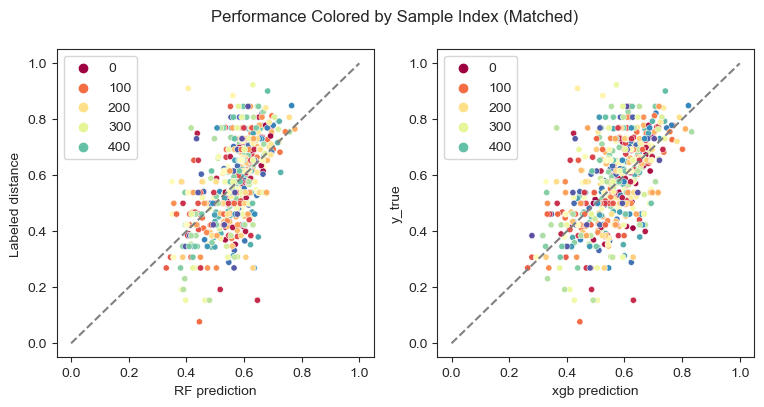

In [94]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = training_set.index, ax = ax[0], s = 20, palette= 'Spectral')
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = training_set.index, ax = ax[1], s = 20, palette= 'Spectral')
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')
fig.suptitle('Performance Colored by Sample Index (Matched)')

plt.show()

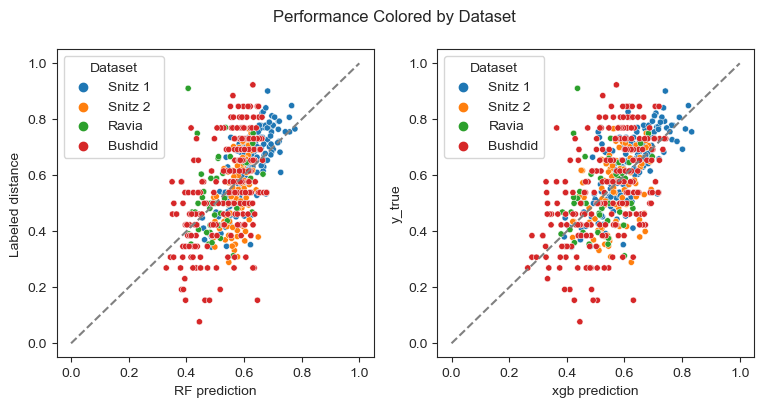

In [95]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Dataset', ax = ax[0], s = 20)
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Dataset', ax = ax[1], s = 20)
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')

fig.suptitle('Performance Colored by Dataset')
plt.show()